In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base = '/content/drive/MyDrive/Database/'
datapath = '/content/drive/MyDrive/Database/LFW'
class_names = sorted(os.listdir(datapath))
print(class_names)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

In [ ]:
no_classes = len(class_names)
print(f"No. of Classes: {no_classes}")

No. of Classes: 5749


In [ ]:
def augment_image(image):
    """
    Augmentasi untuk satu gambar
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def augment_pairs(image1, image2):
    """
    Augmentasi untuk pasangan gambar
    """
    return augment_image(image1), augment_image(image2)


In [ ]:
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIM = 112

# Fungsi untuk memuat gambar dan mengubah ukuran
def load_image(filepath):
   image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
   image = cv2.resize(image, (DIM, DIM))
   return image

# Fungsi augmentasi (tambahkan transformasi jika diperlukan)
def augment_pairs(image_1, image_2):
   datagen = ImageDataGenerator(
       rotation_range=20,
       width_shift_range=0.2,
       height_shift_range=0.2,
       shear_range=0.2,
       zoom_range=0.2,
       horizontal_flip=True,
       fill_mode='nearest'
   )

   image_1 = np.expand_dims(image_1, axis=0)
   image_2 = np.expand_dims(image_2, axis=0)
   # Augmentasi gambar
   image_1 = datagen.random_transform(image_1[0])
   image_2 = datagen.random_transform(image_2[0])

   return image_1, image_2

# Fungsi untuk menampilkan pasangan gambar
def display_pair(pairs, index):
   i = index
   plt.imshow(pairs[i][0])
   plt.show()
   plt.imshow(pairs[i][1])
   plt.show()

# Fungsi untuk membuat pasangan identik
def add_identical_pairs(full_path, selected):
   first, second = selected[0], selected[1]
   dir_list = os.listdir(full_path)
   image_1 = load_image(os.path.join(full_path, dir_list[first]))
   image_2 = load_image(os.path.join(full_path, dir_list[second]))
   return [image_1, image_2]

# Fungsi untuk membuat pasangan berbeda
def add_different_pairs(path1, path2, i, j):
   dir_list1, dir_list2 = os.listdir(path1), os.listdir(path2)
   im_path1 = os.path.join(path1, dir_list1[i])
   im_path2 = os.path.join(path2, dir_list2[j])
   image_1 = load_image(im_path1)
   image_2 = load_image(im_path2)
   return [image_1, image_2]

# Fungsi untuk membuat pasangan gambar
def create_pairs(size):
   pairs = []
   labels = []

   for i in range(size):
       print(f">> {i}")
       gen_count = 1
       while gen_count == 1:
           c = random.randrange(0, no_classes)
           dir_name = class_names[c]
           full_path = os.path.join(datapath, dir_name)
           gen_count = len(os.listdir(full_path))

       # Pasangan identik
       selected = random.sample(range(gen_count), 2)
       image_1, image_2 = add_identical_pairs(full_path, selected)
       image_1, image_2 = augment_pairs(image_1, image_2)  # Terapkan augmentasi
       pairs.append([image_1, image_2])
       labels.append(1)

       # Pasangan berbeda
       c1, c2 = random.sample(range(no_classes), 2)
       dir1, dir2 = class_names[c1], class_names[c2]
       path1, path2 = os.path.join(datapath, dir1), os.path.join(datapath, dir2)
       count1, count2 = len(os.listdir(path1)), len(os.listdir(path2))
       i, j = random.randrange(0, count1), random.randrange(0, count2)
       image_1, image_2 = add_different_pairs(path1, path2, i, j)
       image_1, image_2 = augment_pairs(image_1, image_2)  # Terapkan augmentasi
       pairs.append([image_1, image_2])
       labels.append(0)

   print("==============================================================")
   return np.array(pairs), np.array(labels).astype('float32')

# Fungsi normalisasi data setelah membuat pasangan
def normalize_data(X_train, X_val, X_test):
   # Menghitung rata-rata dan standar deviasi dari data pelatihan
   mean = np.mean(X_train), np.std(X_train)
   X_train = (X_train - mean[0]) / mean[1]
   X_val = (X_val - mean[0]) / mean[1]
   X_test = (X_test - mean[0]) / mean[1]
   return X_train, X_val, X_test

In [ ]:
train_size = 300
val_size = 100
test_size = 50

# Buat pasangan data
X_train, y_train = create_pairs(train_size)
X_val, y_val = create_pairs(val_size)
X_test, y_test = create_pairs(test_size)

# Normalisasi data setelah pasangan dibuat
X_train, X_val, X_test = normalize_data(X_train, X_val, X_test)

# Periksa dimensi data
print(X_train.shape, X_val.shape, X_test.shape)

>> 0
>> 1
>> 2
>> 3
>> 4
>> 5
>> 6
>> 7
>> 8
>> 9
>> 10
>> 11
>> 12
>> 13
>> 14
>> 15
>> 16
>> 17
>> 18
>> 19
>> 20
>> 21
>> 22
>> 23
>> 24
>> 25
>> 26
>> 27
>> 28
>> 29
>> 30
>> 31
>> 32
>> 33
>> 34
>> 35
>> 36
>> 37
>> 38
>> 39
>> 40
>> 41
>> 42
>> 43
>> 44
>> 45
>> 46
>> 47
>> 48
>> 49
>> 50
>> 51
>> 52
>> 53
>> 54
>> 55
>> 56
>> 57
>> 58
>> 59
>> 60
>> 61
>> 62
>> 63
>> 64
>> 65
>> 66
>> 67
>> 68
>> 69
>> 70
>> 71
>> 72
>> 73
>> 74
>> 75
>> 76
>> 77
>> 78
>> 79
>> 80
>> 81
>> 82
>> 83
>> 84
>> 85
>> 86
>> 87
>> 88
>> 89
>> 90
>> 91
>> 92
>> 93
>> 94
>> 95
>> 96
>> 97
>> 98
>> 99
>> 100
>> 101
>> 102
>> 103
>> 104
>> 105
>> 106
>> 107
>> 108
>> 109
>> 110
>> 111
>> 112
>> 113
>> 114
>> 115
>> 116
>> 117
>> 118
>> 119
>> 120
>> 121
>> 122
>> 123
>> 124
>> 125
>> 126
>> 127
>> 128
>> 129
>> 130
>> 131
>> 132
>> 133
>> 134
>> 135
>> 136
>> 137
>> 138
>> 139
>> 140
>> 141
>> 142
>> 143
>> 144
>> 145
>> 146
>> 147
>> 148
>> 149
>> 150
>> 151
>> 152
>> 153
>> 154
>> 155
>> 156
>> 157
>> 1

In [ ]:
import pickle

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)

np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

In [ ]:
X_train, y_train = np.load("X_train.npy"), np.load("y_train.npy")
X_val, y_val = np.load("X_val.npy"), np.load("y_val.npy")

In [ ]:
X_train.shape, y_train.shape

((600, 2, 112, 112, 3), (600,))

In [ ]:
def initialize_base_branch():
    input = keras.layers.Input(shape=(DIM, DIM, 3), name="base_input")

    # Blok Konvolusi 1
    x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Blok Konvolusi 2
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Blok Konvolusi 3
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Blok Konvolusi 4
    x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(2048, activation="relu")(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(2048, activation="relu")(x)

    return Model(inputs=input, outputs=x)

base_model = initialize_base_branch()

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
input_l = Input(shape=(DIM, DIM, 3), name='left_input')
vect_output_l = base_model(input_l)

input_r = Input(shape=(DIM, DIM, 3), name='right_input')
vect_output_r = base_model(input_r)

output = Lambda(euclidean_distance, name='output_layer',
                output_shape=eucl_dist_output_shape)([vect_output_l, vect_output_r])

model = Model([input_l, input_r], output)

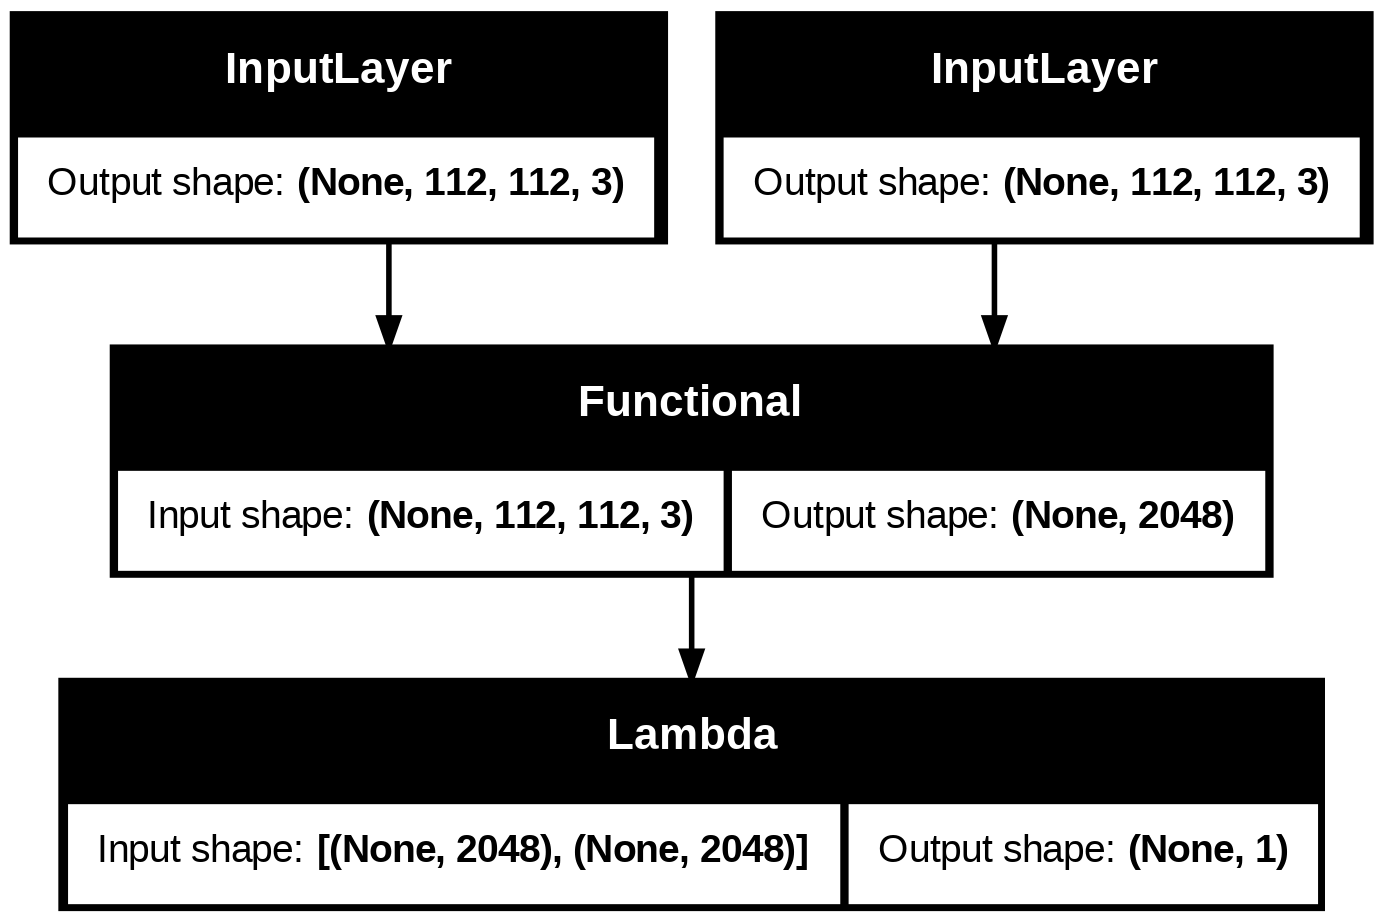

In [ ]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='siamese_model.png', show_shapes=True)

In [ ]:
import tensorflow as tf

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.square(y_pred)  # Use TensorFlow's square function
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))  # Use TensorFlow's square function
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

def accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, tf.float32)), tf.float32))

In [ ]:
rms = RMSprop(learning_rate=0.0001)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=50, validation_data=[[X_val[:, 0], X_val[:, 1]], y_val], batch_size= 16)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - loss: 0.1079 - val_loss: 0.3176
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - loss: 0.0995 - val_loss: 0.2955
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - loss: 0.1009 - val_loss: 0.3483
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 0.0875 - val_loss: 0.3107
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0884 - val_loss: 0.3463
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.0864 - val_loss: 0.3169
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.0848 - val_loss: 0.3520
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - loss: 0.0873 - val_loss: 0.3168
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - loss: 0.0752 - val_loss: 0.3687
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - loss: 0.0826 - val_loss: 0.2931
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 0.0678 - val_loss: 0.2817
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 0.0

In [ ]:
loss = model.evaluate([X_val[:, 0], X_val[:, 1]], y_val)

y_pred_train = model.predict([X_train[:, 0], X_train[:, 1]])
train_accuracy = compute_accuracy(y_train, y_pred_train)

y_pred_val = model.predict([X_val[:, 0], X_val[:, 1]])
val_accuracy = compute_accuracy(y_val, y_pred_val)

print("Loss = {}, Train Accuracy = {}% Test Accuracy = {}%".format(loss, train_accuracy*100, val_accuracy*100))


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.3501
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Loss = 0.32582199573516846, Train Accuracy = 99.5% Test Accuracy = 60.0%


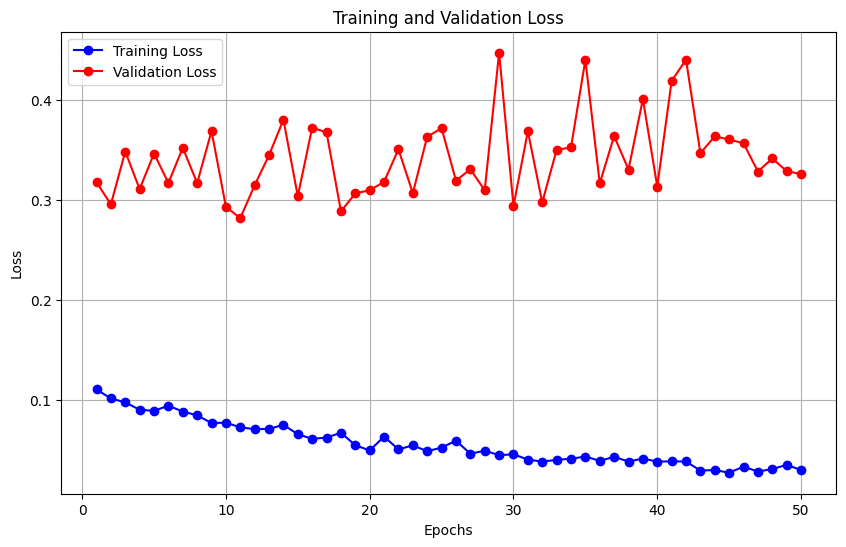

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan grafik loss
def plot_loss(history):
    # Ekstrak loss dan val_loss dari history
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)  # Nomor epoch

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Panggil fungsi dengan history yang disimpan saat pelatihan
plot_loss(history.history)
